- **Baseline dynamics** and phase/tipping structure
- **Network topology comparisons** (grid, small-world, Erd\H{o}s--R\'enyi, Barab\'asi--Albert)
- **Policy interventions**: timed subsidies and targeted seeding
- Export of intermediate results to **CSV** and final figures to `plots/`

**Reproducibility.** All stochastic experiments are repeated across a fixed list of random seeds (`SEEDS`).
Adjust `SEEDS` upward only if runtime allows.

> Tip: Run the notebook from top to bottom. All outputs are deterministic given the seed list.


In [6]:
# Setup: imports, output directory, global seed list

import os, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from ev_core import EVStagHuntModel, set_initial_adopters
import ev_experiments as evx
import ev_plotting as evp

# Output directory for plots
PLOTS_DIR = os.path.join(os.getcwd(), "plots")
os.makedirs(PLOTS_DIR, exist_ok=True)

# Numpy and Pandas display options
np.set_printoptions(suppress=True, precision=4)
pd.set_option("display.max_columns", 200)

# Generate a list of seeds
def seed_list(seed_base=42, n=20):
    return list(range(seed_base, seed_base+n))

SEEDS = seed_list(100, 25) 

In [3]:
# === Global parameters and network constructors ===
# Global defaults (can be changed once you see the tipping boundary)
BASE = dict(
    T=250,
    n_nodes=200,
    b=1.0,
    g_I=0.10,
    I0=0.05,
    beta_I=2.0,
    ratio=2.1,      # sets a0 via a0 = ratio*b - beta_I*I0
    strategy_choice_func="logit",
    tau=1.0,
)

# Network configurations
NETWORKS = {
    "grid":       dict(network_type="grid",       n_nodes=196, p=0.0, m=2, grid_k=6, rewire_p=0.05),
    "small_world":dict(network_type="small_world",n_nodes=200, p=0.0, m=2, grid_k=6, rewire_p=0.05),
    "ER":         dict(network_type="random",     n_nodes=200, p=0.05, m=2, grid_k=6, rewire_p=0.05),
    "BA":         dict(network_type="BA",         n_nodes=200, p=0.05, m=2, grid_k=6, rewire_p=0.05),
}

# === Helper: run model and return dataframe ===
def run_model_df(*, X0_frac, I0, beta_I, ratio, network_key, seed, T=None, policy=None, init_method="random"):
    cfg = NETWORKS[network_key].copy()
    T = BASE["T"] if T is None else int(T)

    # Scenario parameters
    scenario = dict(
        ratio=float(ratio),
        beta_I=float(beta_I),
        b=float(BASE["b"]),
        g_I=float(BASE["g_I"]),
        I0=float(I0),
        X0_frac=float(X0_frac),
        init_method=init_method,
        **cfg,
    )

    # Run experiment
    X, I, df = evx.run_timeseries_trial(
        T=T,
        scenario_kwargs=scenario,
        seed=int(seed),
        policy=policy,
        strategy_choice_func=BASE["strategy_choice_func"],
        tau=BASE["tau"],
    )
    df = df.copy()
    df["t"] = np.arange(len(df))
    return X, I, df

# === Helper: time to reach adoption threshold ===
def time_to_threshold(X, thr=0.8):
    idx = np.where(np.asarray(X) >= thr)[0]
    return float(idx[0]) if len(idx) else np.nan


# Part 1 — Network structure analysis

We compare **grid**, **small-world**, **ER**, **BA** on:
- **speed of adoption**: time to X≥0.8 (conditional on success)
- **P(high adoption)**: fraction of runs with X(T)≥0.8
- **cluster formation**: largest adopting component fraction (final)
- **network-specific tipping sensitivity**: tipping curves vs X₀ (same parameters)


In [4]:
# === Helper: compute adopter cluster statistics at final time ===
import networkx as nx

# Compute size of largest adopter cluster and number of clusters
def final_cluster_stats(model: EVStagHuntModel):
    adopters=[]
    # Collect adopter positions
    for a in model.schedule.agents:
        if a.strategy == "C":
            adopters.append(a.pos)
    # If no adopters, return zeros
    if not adopters:
        return 0.0, 0
    sub = model.G.subgraph(adopters)
    comps = list(nx.connected_components(sub))
    sizes = sorted([len(c) for c in comps], reverse=True)
    # Return relative size of largest cluster and number of clusters
    return sizes[0]/model.G.number_of_nodes(), len(sizes)

# === Helper: run model and return model instance and dataframe ===
def run_model_return_model(*, X0_frac, I0, beta_I, ratio, network_key, seed, T=None, policy=None, init_method="random"):
    cfg = NETWORKS[network_key].copy()
    T = BASE["T"] if T is None else int(T)

    # Compute a0 from ratio, beta_I, I0
    a0 = float(ratio)*float(BASE["b"]) - float(beta_I)*float(I0)
    # Initialize model
    model = EVStagHuntModel(
        a0=a0, beta_I=beta_I, b=BASE["b"], g_I=BASE["g_I"], I0=I0,
        seed=seed,
        collect=True,
        X0_frac=0.0, # we seed below
        init_method=init_method,
        strategy_choice_func=BASE["strategy_choice_func"],
        tau=BASE["tau"],
        **cfg,
    )
    # Set initial adopters
    if X0_frac>0:
        set_initial_adopters(model, X0_frac, method=init_method, seed=seed)

    # Run model
    for t in range(T):
        if policy is not None:
            policy(model, t)
        model.step()

    # Get dataframe
    df = model.datacollector.get_model_vars_dataframe().copy()
    df["t"] = np.arange(len(df))
    return model, df


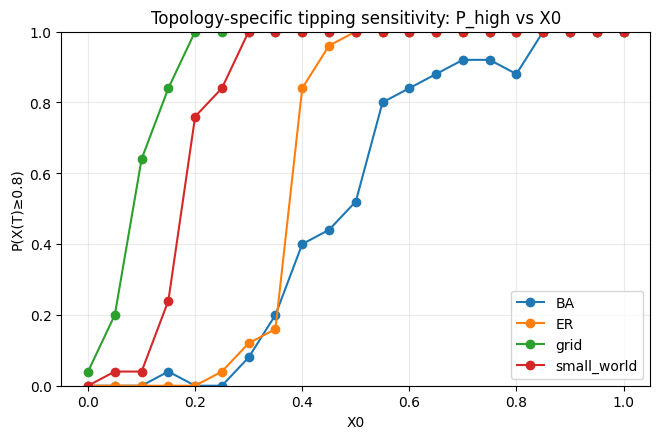

In [ ]:
# === Sweep initial adoption X0 across networks to estimate tipping curves ===
# 2B) Network-specific tipping curves: sweep X0 and compare P_high(X0)
X0s = np.linspace(0.0, 1.0, 21)


rows=[]
for net in NETWORKS.keys():
    # Sweep X0
    for X0 in X0s:
        finals=[]
        # Sweep seeds
        for s in SEEDS:
            # Run model
            X, I, df = run_model_df(X0_frac=X0, I0=BASE["I0"], beta_I=BASE["beta_I"], ratio=BASE["ratio"], network_key=net, seed=s)
            finals.append(float(X[-1]))
        finals=np.asarray(finals)
        # Store results
        rows.append((net, float(X0), float(np.mean(finals>=0.8)), float(np.mean(finals))))

# Create tipping dataframe
tip_df = pd.DataFrame(rows, columns=["network","X0","P_high","X_final_mean"])

# Plot tipping curves
def plot_tip_curves(df):
    fig, ax = plt.subplots(figsize=(7.6,4.6))
    for net, g in df.groupby("network"):
        g = g.sort_values("X0")
        ax.plot(g["X0"], g["P_high"], marker="o", label=net)
    ax.set_ylim(0,1)
    ax.set_xlabel("X0")
    ax.set_ylabel("P(X(T)≥0.8)")
    ax.set_title("Topology-specific tipping sensitivity: P_high vs X0")
    ax.grid(True, alpha=0.25)
    ax.legend()
    return fig

# Generate and save plot
fig = plot_tip_curves(tip_df)
out = os.path.join(PLOTS_DIR, "P2_tipping_curves_Phigh_vs_X0.png")
fig.savefig(out, dpi=160, bbox_inches="tight")
plt.show()
print("Saved:", out)

# Save tipping dataframe
tip_df.to_csv(os.path.join(PLOTS_DIR, "P2_tipping_curves.csv"), index=False)


# Part 3 — Policy intervention design & evaluation

We implement two interventions motivated by common vulnerabilities:

1) **Timed subsidy** 
2) **Targeted seeding** of **high-degree/central nodes**



In [ ]:
# === Policy definitions: subsidy and targeted seeding (returned as factories) ===
# Policy factories (use patched ev_experiments)

# Timed subsidy factory
subsidy = lambda start, end, da0: (
    lambda: evx.policy_subsidy_factory(start=start, end=end, delta_a0=float(da0), delta_beta_I=0.0)
)

# Targeted seeding factory
seed_high = lambda t0, frac: (
    lambda: evx.policy_targeted_seeding_factory(start=int(t0), frac=float(frac), once=True, high=True)
)

# === Evaluate policies over multiple seeds and collect statistics ===
def eval_policy(*, network_key, policy_spec, label, X0_frac, I0, beta_I, ratio, T=None):
    if T is None:
        T = BASE["T"]

    finals = []
    t80 = []

    for s in SEEDS:
        # If policy_spec is a factory, call it to get a fresh policy for each run
        if policy_spec is None:
            pol = None
        else:
            pol = policy_spec() if callable(policy_spec) else policy_spec
        # Run model
        X, I, df = run_model_df(
            X0_frac=X0_frac, I0=I0, beta_I=beta_I, ratio=ratio,
            network_key=network_key, seed=s, T=T, policy=pol
        )
        # Collect final adoption and time to 80% adoption
        finals.append(float(X[-1]))
        t80.append(time_to_threshold(X, 0.8))
    # Convert to numpy arrays
    finals = np.asarray(finals, dtype=float)
    t80 = np.asarray(t80, dtype=float)

    successes = finals >= 0.8
    t80_cens = np.where(np.isnan(t80), T + 1, t80)
    
    # Return statistics
    return dict(
        network=network_key,
        policy=label,
        X0_frac=float(X0_frac), I0=float(I0), beta_I=float(beta_I), ratio=float(ratio), T=int(T),
        X_final_mean=float(np.mean(finals)),
        X_final_median=float(np.median(finals)),
        X_final_sd=float(np.std(finals)),
        P_high=float(np.mean(successes)),
        t_to_0p8_mean=float(np.nanmean(t80)) if np.any(~np.isnan(t80)) else np.nan,
        t_to_0p8_mean_cond=float(np.nanmean(t80[successes])) if np.any(successes) else np.nan,
        t80_censored_mean=float(np.mean(t80_cens)),
        t80_censored_median=float(np.median(t80_cens)),
    )


In [ ]:
# === Near-critical search: choose X0 such that baseline P_high is near target ===
def find_near_critical_X0(network_key, target_P=0.25, grid=np.linspace(0.05, 0.70, 14)):
    """
    Picks X0_frac that puts THIS network near the tipping boundary:
    - P_high near target_P
    - X_final_mean near 0.5 (avoids trivial all-0 or all-1 regimes)
    """
    best = None
    best_score = float("inf")
    
    # Sweep X0 grid
    for x0 in grid:
        r = eval_policy(
            network_key=network_key,
            policy_spec=None,
            label="baseline_probe",
            X0_frac=float(x0),
            I0=BASE["I0"],
            beta_I=BASE["beta_I"],
            ratio=BASE["ratio"],
            T=BASE["T"],
        )
        # Combine distance from target_P and from 0.5 final adoption
        score = abs(r["P_high"] - target_P) + 0.35 * abs(r["X_final_mean"] - 0.5)

        if score < best_score:
            best_score = score
            best = (float(x0), r)

    x0, r = best
    return dict(X0_frac=x0, baseline=r, score=float(best_score))

# Find near-critical X0 for each network
nearcrit = {net: find_near_critical_X0(net, target_P=0.375) for net in NETWORKS.keys()}

# Display near-critical results
pd.DataFrame([{
    "network": net,
    "X0_frac": v["X0_frac"],
    "baseline_P_high": v["baseline"]["P_high"],
    "baseline_X_final_mean": v["baseline"]["X_final_mean"],
    "baseline_t80_cens": v["baseline"]["t80_censored_mean"],
} for net, v in nearcrit.items()]).sort_values("network")

,network,X0_frac,baseline_P_high,baseline_X_final_mean,baseline_t80_cens
3,BA,0.40,0.40,0.416600,150.84
2,ER,0.35,0.16,0.206200,211.24
0,grid,0.05,0.20,0.200816,202.32
1,small_world,0.15,0.24,0.240000,192.48


In [ ]:
# === Policy sweep: evaluate subsidy windows/intensities and seeding times/fracs ===
subsidy_windows = [(0, 60), (20, 80), (60, 120)]
subsidy_intensities = [0.2, 0.4, 0.6]

seed_times = [10, 40, 80]
seed_fracs = [0.02, 0.05, 0.10]

rows = []

# Sweep networks and policies
for net in NETWORKS.keys():
    POL_BASE = dict(
        X0_frac=nearcrit[net]["X0_frac"],
        I0=BASE["I0"],
        beta_I=BASE["beta_I"],
        ratio=BASE["ratio"],
        T=BASE["T"],
    )

    # baseline
    rows.append(eval_policy(network_key=net, policy_spec=None, label="baseline", **POL_BASE))

    # subsidies
    for (start, end) in subsidy_windows:
        for da0 in subsidy_intensities:
            rows.append(eval_policy(
                network_key=net,
                policy_spec=subsidy(start, end, da0),
                label=f"subsidy[{start}-{end},da0={da0}]",
                **POL_BASE
            ))

    # targeted seeding
    for t0 in seed_times:
        for frac in seed_fracs:
            rows.append(eval_policy(
                network_key=net,
                policy_spec=seed_high(t0, frac),
                label=f"seed[t={t0},frac={frac}]",
                **POL_BASE
            ))

pol_df = pd.DataFrame(rows)
pol_df.head()

,network,policy,X0_frac,I0,beta_I,ratio,T,X_final_mean,X_final_median,X_final_sd,P_high,t_to_0p8_mean,t_to_0p8_mean_cond,t80_censored_mean,t80_censored_median
0,grid,baseline,0.05,0.05,2.0,2.1,250,0.200816,0.0,0.399612,0.2,7.6,7.6,202.32,251.0
1,grid,"subsidy[0-60,da0=0.2]",0.05,0.05,2.0,2.1,250,0.200816,0.0,0.399612,0.2,7.6,7.6,202.32,251.0
2,grid,"subsidy[0-60,da0=0.4]",0.05,0.05,2.0,2.1,250,0.200816,0.0,0.399612,0.2,7.6,7.6,202.32,251.0
3,grid,"subsidy[0-60,da0=0.6]",0.05,0.05,2.0,2.1,250,0.200816,0.0,0.399612,0.2,7.6,7.6,202.32,251.0
4,grid,"subsidy[20-80,da0=0.2]",0.05,0.05,2.0,2.1,250,0.200816,0.0,0.399612,0.2,7.6,7.6,202.32,251.0


In [ ]:
# === Policy scoring: compute costs, deltas vs baseline, and top policy tables ===
def policy_cost(label):
    # crude proxy: subsidy cost ~ da0 * duration, seeding cost ~ frac
    if label.startswith("subsidy["):
        inside = label.split("[", 1)[1].rstrip("]")
        window, da0part = inside.split(",")
        start, end = window.split("-")
        da0 = float(da0part.split("=")[1])
        return da0 * (int(end) - int(start))
    if label.startswith("seed["):
        inside = label.split("[", 1)[1].rstrip("]")
        frac = float([p for p in inside.split(",") if "frac=" in p][0].split("=")[1])
        return frac
    return 0.0

base = pol_df[pol_df["policy"] == "baseline"].set_index("network")

# Compute deltas vs baseline
pol_df["dP_high"] = pol_df.apply(lambda r: r["P_high"] - float(base.loc[r["network"], "P_high"]), axis=1)
pol_df["dX_final"] = pol_df.apply(lambda r: r["X_final_mean"] - float(base.loc[r["network"], "X_final_mean"]), axis=1)
pol_df["dt80_cens"] = pol_df.apply(lambda r: r["t80_censored_mean"] - float(base.loc[r["network"], "t80_censored_mean"]), axis=1)

# conditional speed delta only if both defined
def safe_dt80_cond(r):
    b = base.loc[r["network"], "t_to_0p8_mean_cond"]
    return (r["t_to_0p8_mean_cond"] - float(b)) if (pd.notna(r["t_to_0p8_mean_cond"]) and pd.notna(b)) else np.nan

pol_df["dt80_cond"] = pol_df.apply(safe_dt80_cond, axis=1)

pol_df["cost"] = pol_df["policy"].apply(policy_cost)
pol_df["dP_per_cost"] = pol_df.apply(lambda r: (r["dP_high"] / r["cost"]) if r["cost"] > 0 else np.nan, axis=1)

# Best policies per network (raw gain)
top_gain = (pol_df[pol_df["policy"] != "baseline"]
            .sort_values(["network", "dP_high"], ascending=[True, False])
            .groupby("network").head(5))

# Best policies per network (efficiency)
top_eff = (pol_df[(pol_df["policy"] != "baseline") & (pol_df["cost"] > 0)]
           .sort_values(["network", "dP_per_cost"], ascending=[True, False])
           .groupby("network").head(5))

display(top_gain[["network","policy","X0_frac","P_high","dP_high","X_final_mean","dX_final","t80_censored_mean","dt80_cens","cost"]])
display(top_eff[["network","policy","X0_frac","dP_high","dP_per_cost","cost"]])

,network,policy,X0_frac,P_high,dP_high,X_final_mean,dX_final,t80_censored_mean,dt80_cens,cost
69,BA,"seed[t=10,frac=0.1]",0.40,1.00,0.60,1.0000,0.583400,6.24,-144.60,0.10
72,BA,"seed[t=40,frac=0.1]",0.40,1.00,0.60,1.0000,0.583400,24.24,-126.60,0.10
75,BA,"seed[t=80,frac=0.1]",0.40,1.00,0.60,1.0000,0.583400,48.24,-102.60,0.10
68,BA,"seed[t=10,frac=0.05]",0.40,0.88,0.48,0.8946,0.478000,35.48,-115.36,0.05
71,BA,"seed[t=40,frac=0.05]",0.40,0.88,0.48,0.8946,0.478000,49.88,-100.96,0.05
41,ER,"subsidy[0-60,da0=0.6]",0.35,1.00,0.84,0.9998,0.793600,1.44,-209.80,36.00
40,ER,"subsidy[0-60,da0=0.4]",0.35,0.84,0.68,0.8572,0.651000,41.92,-169.32,24.00
39,ER,"subsidy[0-60,da0=0.2]",0.35,0.64,0.48,0.6714,0.465200,92.04,-119.20,12.00
50,ER,"seed[t=10,frac=0.1]",0.35,0.48,0.32,0.4936,0.287400,134.96,-76.28,0.10
53,ER,"seed[t=40,frac=0.1]",0.35,0.48,0.32,0.4936,0.287400,144.56,-66.68,0.10


,network,policy,X0_frac,dP_high,dP_per_cost,cost
68,BA,"seed[t=10,frac=0.05]",0.40,0.48,9.6,0.05
71,BA,"seed[t=40,frac=0.05]",0.40,0.48,9.6,0.05
74,BA,"seed[t=80,frac=0.05]",0.40,0.48,9.6,0.05
69,BA,"seed[t=10,frac=0.1]",0.40,0.60,6.0,0.10
72,BA,"seed[t=40,frac=0.1]",0.40,0.60,6.0,0.10
50,ER,"seed[t=10,frac=0.1]",0.35,0.32,3.2,0.10
53,ER,"seed[t=40,frac=0.1]",0.35,0.32,3.2,0.10
56,ER,"seed[t=80,frac=0.1]",0.35,0.32,3.2,0.10
49,ER,"seed[t=10,frac=0.05]",0.35,0.12,2.4,0.05
52,ER,"seed[t=40,frac=0.05]",0.35,0.12,2.4,0.05


In [ ]:
# === Export: write policy CSV outputs used in the report ===
top_eff.to_csv(os.path.join(PLOTS_DIR, "P3_top_effective_policies_new.csv"), index=False)
top_gain.to_csv(os.path.join(PLOTS_DIR, "P3_top_gaining_policies_new.csv"), index=False)
pol_df.to_csv(os.path.join(PLOTS_DIR, "P3_all_policy_evaluations.csv"), index=False)
print("Saved top policies to CSV in", PLOTS_DIR)

Saved top policies to CSV in c:\Users\jfresen\OneDrive - ONVZ Ziektekostenverzekeraar N.V\Bureaublad\Complex Systems & Policy\Model Based Decision Making\Assignment3_MBDM_Dekker_Fresen\chat_policy_code\plots


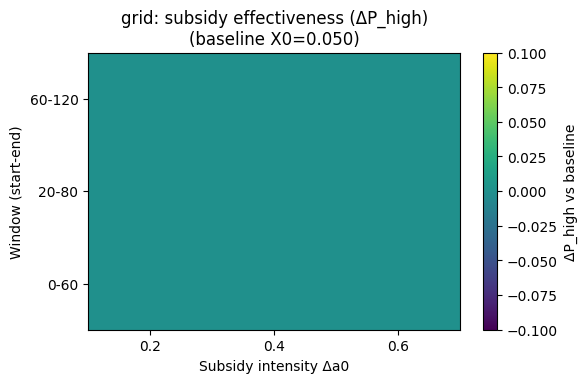

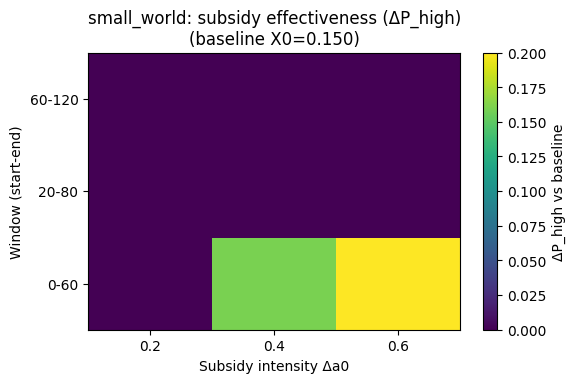

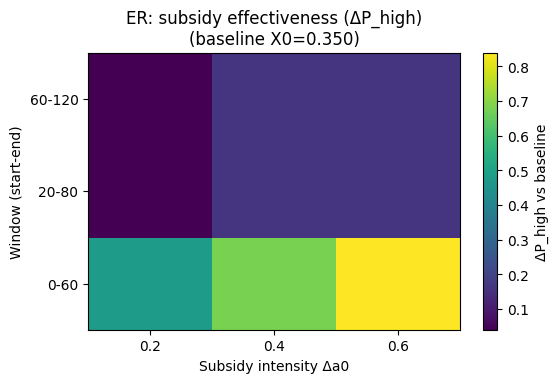

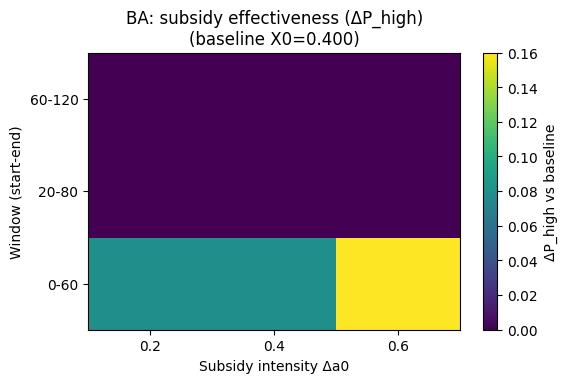

In [ ]:
# === Plotting: create per-topology subsidy heatmaps (ΔP_high) ===
for net in NETWORKS.keys():
    sub = pol_df[(pol_df["network"] == net) & (pol_df["policy"].str.startswith("subsidy["))].copy()

    sub["window"] = sub["policy"].str.extract(r"subsidy\[(\d+-\d+),")[0]
    sub["da0"] = sub["policy"].str.extract(r"da0=([0-9.]+)\]")[0].astype(float)

    pivot = sub.pivot(index="window", columns="da0", values="dP_high")
    pivot = pivot.reindex(index=[f"{a}-{b}" for (a,b) in subsidy_windows], columns=subsidy_intensities)

    plt.figure(figsize=(6, 3.6))
    plt.imshow(pivot.to_numpy(), aspect="auto", origin="lower")
    plt.xticks(range(len(pivot.columns)), pivot.columns)
    plt.yticks(range(len(pivot.index)), pivot.index)
    plt.colorbar(label="ΔP_high vs baseline")
    plt.xlabel("Subsidy intensity Δa0")
    plt.ylabel("Window (start-end)")
    plt.title(f"{net}: subsidy effectiveness (ΔP_high)\n(baseline X0={nearcrit[net]['X0_frac']:.3f})")
    plt.show()